In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from joblib import Memory
import scipy.stats as st

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error

# Tree-based models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [3]:
train_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\train_cleaned_FE.csv"
df = pd.read_csv(train_file)

In [4]:
df = df.drop(columns=['MRP_by_Outlet_Type'])
categorical_cols = ['Item', 'Outlet', 'Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
numerical_cols = ['Item_MRP', 'Item_Weight', 'Item_Visibility','Years_Since_Establishment', 
                  'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item                        8523 non-null   object 
 1   Item_Weight                 8523 non-null   float64
 2   Item_Fat_Content            8523 non-null   object 
 3   Item_Visibility             8523 non-null   float64
 4   Item_Type                   8523 non-null   object 
 5   Item_MRP                    8523 non-null   float64
 6   Outlet                      8523 non-null   object 
 7   Years_Since_Establishment   8523 non-null   int64  
 8   Outlet_Size                 8523 non-null   object 
 9   Outlet_Location_Type        8523 non-null   object 
 10  Outlet_Type                 8523 non-null   object 
 11  Item_Outlet_Sales           8523 non-null   float64
 12  Mean_Sales_Outlet_Type      8523 non-null   float64
 13  Avg_Sales_by_Location_Type  8523 

In [6]:
def tune_model(model, param_distributions, X, y, preprocessor, n_iter=10, cv=5, random_state=42):
    """
    Build a pipeline with the preprocessor and the model, and run RandomizedSearchCV.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory=memory)  # Cache intermediate steps
    
    rsearch = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=rmse_scorer,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rsearch.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {rsearch.best_params_}")
    return rsearch.best_estimator_

In [7]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

In [8]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [9]:
gbr_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 10)
}

xgb_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),
    'model__min_child_weight': st.randint(1, 10)
}

lgbm_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),
    'model__min_child_samples': st.randint(5, 50)
}

rf_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__max_depth': st.randint(3, 15),
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 20)
}

etr_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__max_depth': st.randint(3, 15),
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 20)
}


cat_params = {
        'model__iterations': st.randint(50, 300),
        'model__learning_rate': st.uniform(0.01, 0.2),
        'model__depth': st.randint(3, 10)
    }

In [10]:
best_models = {}

print("Tuning GradientBoostingRegressor...")
best_models['gbr'] = tune_model(GradientBoostingRegressor(random_state=42), gbr_params, X, y, preprocessor)

print("Tuning XGBRegressor...")
best_models['xgb'] = tune_model(XGBRegressor(objective='reg:squarederror', random_state=42), xgb_params, X, y, preprocessor)

print("Tuning LGBMRegressor...")
best_models['lgbm'] = tune_model(LGBMRegressor(random_state=42), lgbm_params, X, y, preprocessor)

print("Tuning RandomForestRegressor...")
best_models['rf'] = tune_model(RandomForestRegressor(random_state=42), rf_params, X, y, preprocessor)

print("Tuning ExtraTreesRegressor...")
best_models['etr'] = tune_model(ExtraTreesRegressor(random_state=42), etr_params, X, y, preprocessor)

print("Tuning CatBoostRegressor...")
best_models['cat'] = tune_model(CatBoostRegressor(verbose=0, random_state=42), cat_params, X, y, preprocessor)

Tuning GradientBoostingRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best params for GradientBoostingRegressor: {'model__learning_rate': 0.1323705789444759, 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 13, 'model__n_estimators': 104, 'model__subsample': 0.9932923543227152}
Tuning XGBRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for XGBRegressor: {'model__learning_rate': 0.1000998503939086, 'model__max_depth': 4, 'model__min_child_weight': 4, 'model__n_estimators': 138, 'model__subsample': 0.9862528132298237}
Tuning LGBMRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\malli\anaconda3\envs\abhi_feb\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 44
[LightGBM] [Info] Start training from score 2181.288915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [14]:
test_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\test_cleaned_FE.csv"
test_data = pd.read_csv(test_file)
test_data = test_data.drop(columns=['MRP_by_Outlet_Type'], errors='ignore')


# Choosing the best models based on CV RMSE
best_model_gbr = best_models['gbr']
test_data_preprocessed = best_model_gbr.named_steps['preprocessor'].transform(test_data)
predictions_gbr = best_model_gbr.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_gbr'] = predictions_gbr
test_data['Predicted_Item_Outlet_Sales_gbr_abs'] = np.abs(predictions_gbr)

best_model_xgb = best_models['xgb']
predictions_xgb = best_model_xgb.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_xgb'] = predictions_xgb
test_data['Predicted_Item_Outlet_Sales_xgb_abs'] = np.abs(predictions_xgb)

best_model_lgbm = best_models['lgbm']
predictions_lgbm = best_model_lgbm.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_lgbm'] = predictions_lgbm
test_data['Predicted_Item_Outlet_Sales_lgbm_abs'] = np.abs(predictions_lgbm)

best_model_rf = best_models['rf']
predictions_rf = best_model_rf.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_rf'] = predictions_rf
test_data['Predicted_Item_Outlet_Sales_rf_abs'] = np.abs(predictions_rf)

best_model_etr = best_models['etr']
predictions_etr = best_model_etr.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_etr'] = predictions_etr
test_data['Predicted_Item_Outlet_Sales_etr_abs'] = np.abs(predictions_etr)

best_model_cat = best_models['cat']
predictions_cat = best_model_cat.named_steps['model'].predict(test_data_preprocessed)
test_data['Predicted_Item_Outlet_Sales_cat'] = predictions_cat
test_data['Predicted_Item_Outlet_Sales_cat_abs'] = np.abs(predictions_cat)

output_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\Decision_tree_models_maximum.csv"
test_data.to_csv(output_file, index=False)
print("Predictions saved to:", output_file)

c:\Users\malli\anaconda3\envs\abhi_feb\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Predictions saved to: C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\Decision_tree_models_maximum.csv


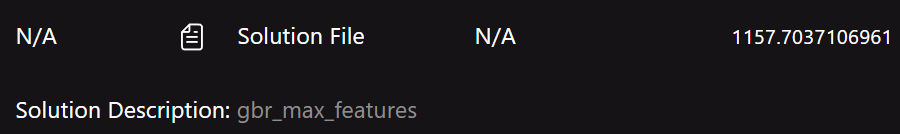

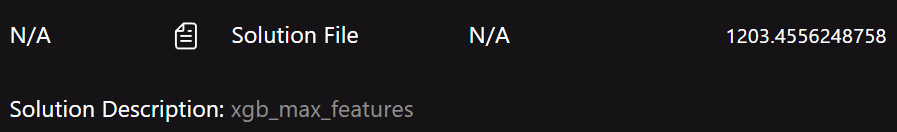

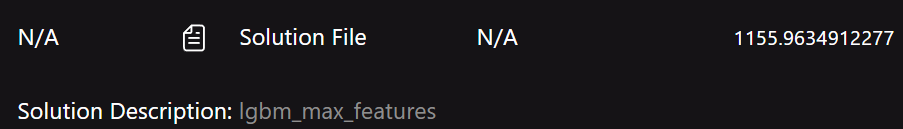

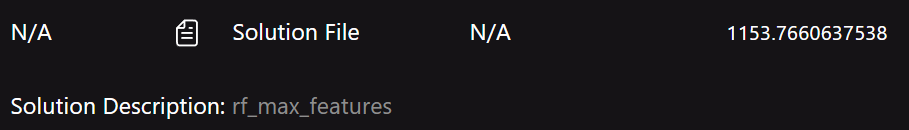

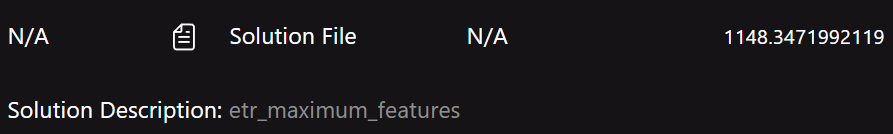

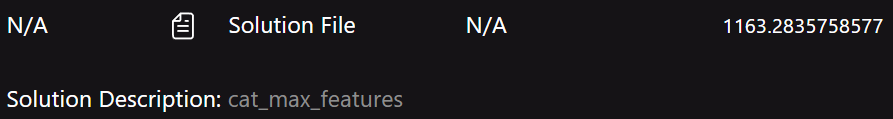

In [15]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\gbr_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_gbr,f)

In [16]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\xgb_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_xgb,f)

In [17]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\lgbm_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_lgbm,f)

In [18]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\rf_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_rf,f)

In [19]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\etr_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_etr,f)

In [20]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\cat_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(best_model_cat,f)